In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.callbacks import EarlyStopping

import random
import pickle

In [2]:
GatheredPatterns = pd.read_csv('제일/chosenPatternJeil.csv')
GatheredPatterns.loc[:,'measure_dtm'] = pd.to_datetime(GatheredPatterns.loc[:,'measure_dtm'])
GatheredPatterns.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29133 entries, 0 to 29132
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   auto_collect_id    29133 non-null  object 
 1   measure_dtm        29133 non-null  object 
 2   attribute_1_value  29133 non-null  float64
 3   attribute_2_value  29133 non-null  int64  
 4   attribute_3_value  29133 non-null  int64  
 5   Peak               29133 non-null  int64  
 6   StartPoint         29133 non-null  int64  
dtypes: float64(1), int64(4), object(2)
memory usage: 1.6+ MB


In [11]:
def createDataset(dataset, window_size, shuffle = None):
    X = []
    y = []
    for i in range(len(dataset) - window_size):
        X.append(dataset[i:(i + window_size)])
        y.append(dataset[i + window_size][0])
    
    X = np.array(X)
    y = np.array(y)
    if (shuffle == True):
        indices = np.random.permutation(len(X))
        X_shuffled = X[indices]
        y_shuffled = y[indices]
    
        return X_shuffled, y_shuffled
    
    else:
        return X, y

window_size = 60
numberOfFeatures = 2

In [12]:
normalData = GatheredPatterns.copy()

temp_min = np.min(normalData.loc[:,'attribute_1_value'].values)
temp_max = np.max(normalData.loc[:,'attribute_1_value'].values - temp_min)

normalData.loc[:,'attribute_1_value'] = (normalData.loc[:,'attribute_1_value'] - temp_min) / temp_max

trainTestSplitLength = int(normalData.shape[0]*0.8)
trainValidSplitLength = int(trainTestSplitLength*0.75)

train = normalData.iloc[:trainValidSplitLength,2:4].values
valid = normalData.iloc[trainValidSplitLength : trainTestSplitLength, 2:4].values
test = normalData.iloc[trainTestSplitLength:,2:4].values


train_X, train_Y = createDataset(train, window_size, shuffle=True)
valid_X, valid_Y = createDataset(valid, window_size, shuffle=False)
test_X, test_Y = createDataset(test,window_size, shuffle=False)

train_X = train_X.reshape(train_X.shape[0], train_X.shape[1], numberOfFeatures)
valid_X = valid_X.reshape(valid_X.shape[0], valid_X.shape[1], numberOfFeatures)

In [14]:
seed_value = 42
np.random.seed(seed_value)       
random.seed(seed_value)          
tf.random.set_seed(seed_value)

def modelLSTMAE():
    model = keras.Sequential()

    model.add(keras.layers.LSTM(64, input_shape = (train_X.shape[1], train_X.shape[2]), activation='relu', return_sequences = True))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(0.2))

    model.add(keras.layers.LSTM(32, return_sequences = True))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(0.2))

    model.add(keras.layers.LSTM(16, return_sequences = False))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(0.2))

    model.add(keras.layers.Dense(8))
    model.add(keras.layers.Dropout(0.2))

    model.add(keras.layers.RepeatVector(train_X.shape[1]))

    model.add(keras.layers.LSTM(16, return_sequences = True))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(0.2))

    model.add(keras.layers.LSTM(32, return_sequences = True))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(0.2))

    model.add(keras.layers.LSTM(64, return_sequences = True))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(0.2))

    model.add(keras.layers.TimeDistributed(keras.layers.Dense(train_X.shape[2])))

    return model

modelLSTMAEver1 = modelLSTMAE()

modelLSTMAEver1.compile(optimizer='adam', loss='mse', metrics=['mse'])
earlyStopping = EarlyStopping( monitor='val_loss', patience=20, verbose=1, restore_best_weights = True)
history = modelLSTMAEver1.fit(train_X, train_X, epochs=500, batch_size=16, validation_data=(valid_X, valid_X), callbacks=[earlyStopping])


Epoch 1/500
1089/1089 [==============================] - 85s 72ms/step - loss: 0.1613 - mse: 0.1613 - val_loss: 0.0466 - val_mse: 0.0466
Epoch 2/500
1089/1089 [==============================] - 77s 71ms/step - loss: 0.0395 - mse: 0.0395 - val_loss: 0.0232 - val_mse: 0.0232
Epoch 3/500
1089/1089 [==============================] - 81s 74ms/step - loss: 0.0281 - mse: 0.0281 - val_loss: 0.0228 - val_mse: 0.0228
Epoch 4/500
1089/1089 [==============================] - 78s 71ms/step - loss: 0.0245 - mse: 0.0245 - val_loss: 0.0172 - val_mse: 0.0172
Epoch 5/500
1089/1089 [==============================] - 78s 71ms/step - loss: 0.0220 - mse: 0.0220 - val_loss: 0.0166 - val_mse: 0.0166
Epoch 6/500
1089/1089 [==============================] - 77s 71ms/step - loss: 0.0199 - mse: 0.0199 - val_loss: 0.0164 - val_mse: 0.0164
Epoch 7/500
1089/1089 [==============================] - 78s 72ms/step - loss: 0.0197 - mse: 0.0197 - val_loss: 0.0145 - val_mse: 0.0145
Epoch 8/500
1089/1089 [==================

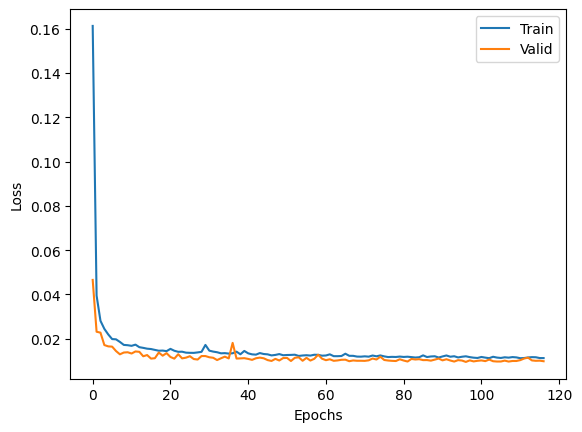

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Valid'])
plt.show()

In [16]:
modelLSTMAEver1.save('modelLSTMAEver10.h5')

In [17]:
trainedLSTMAEModel = keras.models.load_model('modelLSTMAEver10.h5')

In [18]:
trainedLSTMAEModel.evaluate(test_X, test_X)

181/181 [==============================] - 3s 15ms/step - loss: 0.0094 - mse: 0.0094


[0.009372536092996597, 0.009372535161674023]

In [19]:
train_X.shape

(17419, 60, 2)

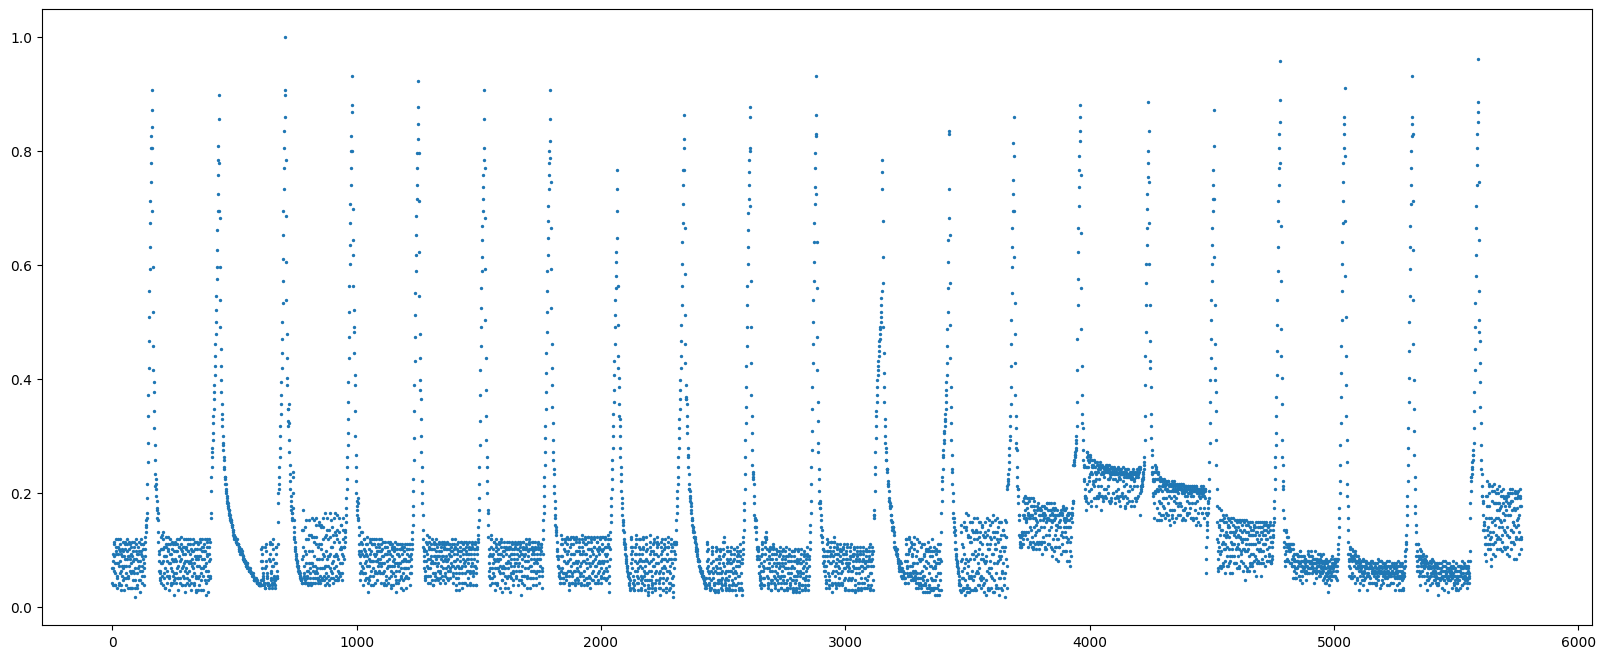

In [20]:
%matplotlib inline
plt.figure(figsize=(20,8))
plt.scatter(np.arange(len(test_X)),test_X[:,0,0], s = 2)
# plt.scatter(np.arange(len(test_X)),test_X[0,:,0], s = 2)
plt.show()

In [21]:
def predictLSTMAE(model, data):
	num_sample = 4000
	result = []
	batch_slice = np.arange(window_size, num_sample, window_size)

	for i in batch_slice:
		batch_data = data[i:i+window_size]
		batch_predictions = model.predict(batch_data)
		result.extend(batch_predictions)
	
	result = np.array(result)
	result = result[:,0,0]
	nan_array = np.full((window_size,), np.nan)
	result = np.hstack((nan_array, result))
	return result

In [22]:
tempResult = predictLSTMAE(trainedLSTMAEModel, test_X)

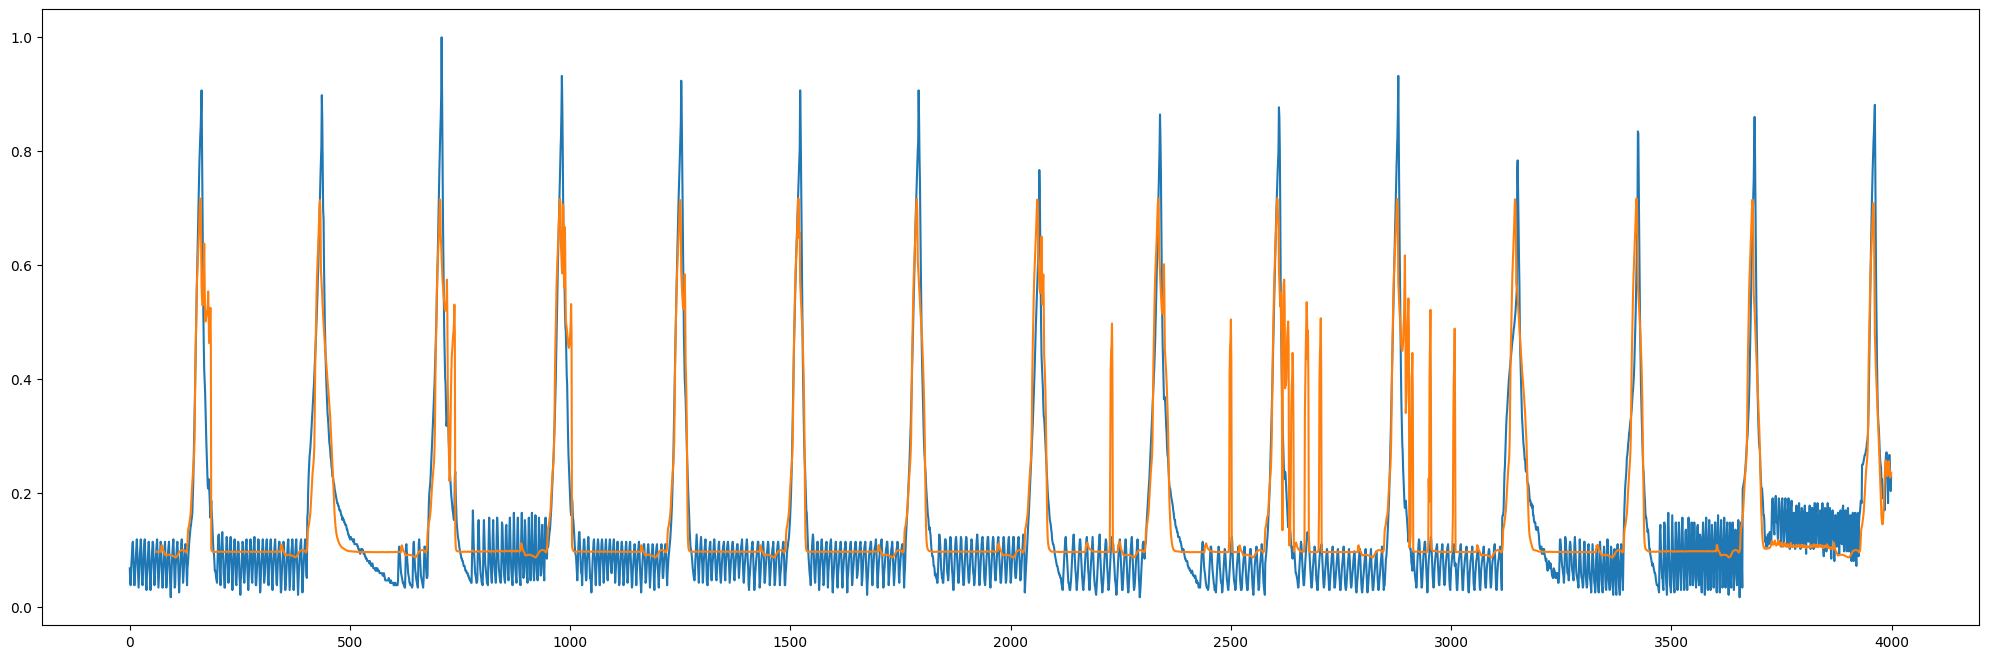

In [23]:
%matplotlib inline
plt.figure(figsize=(25,8))
plt.plot(np.arange(4000), test[:4000,0])
plt.plot(np.arange(4000), tempResult[:4000])
plt.show()

In [127]:
def plotReconstruction(data, number = None, title = None):
    beforeTemp = data[number].reshape(-1,30,2)
    afterTemp = trainedLSTMAEModel.predict(beforeTemp)

    plt.figure(figsize = (25,8))
    plt.plot(np.arange(len(beforeTemp[0][:,0])), beforeTemp[0][:,0])
    plt.plot(np.arange(len(afterTemp[0][:,0])), afterTemp[0][:,0])
    plt.title(title)
    plt.xlabel('Index of time')
    plt.ylabel('attribute_1_value (scaled)')
    plt.legend(['Model Input', 'Model Output'])
    plt.show()

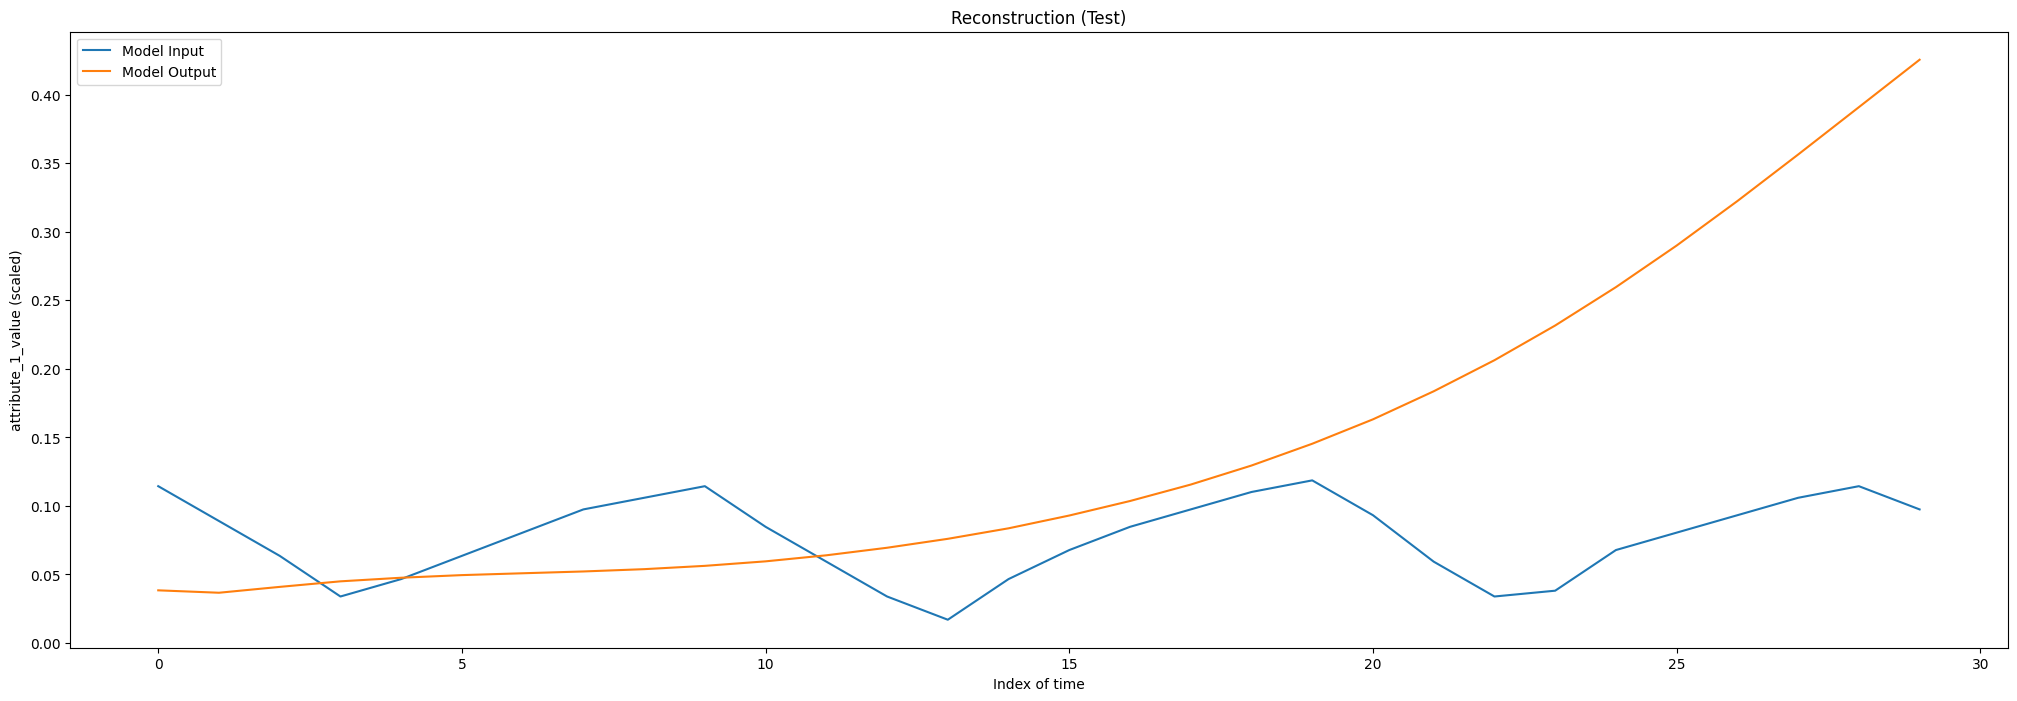

In [128]:
plotReconstruction(test_X, 80, 'Reconstruction (Test)')